In [1]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
import os

print("Loading model...")
model_id = "Qwen/Qwen3-VL-2B-Instruct"
# model = AutoModelForImageTextToText.from_pretrained(
#     model_id,
#     torch_dtype=torch.bfloat16,
#     attn_implementation="sdpa", # Changed from flash_attention_2 to sdpa to avoid extra dependencies
#     # device_map="auto",
#     # Force single-GPU placement
#     device_map={"": 0} if torch.cuda.is_available() else None,
#     # use_cache=False # Important for training with gradient checkpointing
# )

from utils.modeling import load_sparse_model
model = load_sparse_model(model_id)

processor = AutoProcessor.from_pretrained(model_id)
tokenizer = processor.tokenizer
tokenizer.pad_token = tokenizer.eos_token


`torch_dtype` is deprecated! Use `dtype` instead!


Loading model...


In [5]:
import types
import torch

def monkey_patch_qwen_generation(model_instance):
    """
    Monkey patches a Qwen3VLForConditionalGeneration instance to support
    custom position_id passthrough during generation.
    """
    
    # We define the custom method. Note that 'self' will be the model instance.
    def custom_prepare_inputs_for_generation(
        self,
        input_ids,
        past_key_values=None,
        attention_mask=None,
        inputs_embeds=None,
        cache_position=None,
        position_ids=None,
        use_cache=True,
        pixel_values=None,
        pixel_values_videos=None,
        image_grid_thw=None,
        video_grid_thw=None,
        **kwargs,
    ):
        # 1. Distinguish Prefill vs. Decoding
        #    If cache_position[0] is 0, we are in the prefill stage (processing the prompt).
        #    Otherwise, we are generating new tokens.
        is_prefill = cache_position is not None and cache_position[0] == 0

        # 2. Call the parent class's logic (GenerationMixin) to handle standard args
        #    Since we are monkey-patching an instance, we use the class explicitly.
        #    (We use the super of the instance's class to be safe).
        model_inputs = super(type(self), self).prepare_inputs_for_generation(
            input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            cache_position=cache_position,
            position_ids=position_ids,
            pixel_values=pixel_values,
            pixel_values_videos=pixel_values_videos,
            image_grid_thw=image_grid_thw,
            video_grid_thw=video_grid_thw,
            use_cache=use_cache,
            **kwargs,
        )

        # 3. Custom Logic
        if is_prefill:
            # --- PREFILL PHASE ---
            # print("DEBUG: Initial generation (Prefill)")
            
            # Pass everything through exactly as provided.
            # If you provided custom position_ids, they are in model_inputs['position_ids']
            # and will be used by forward().
            pass

        else:
            # --- DECODING PHASE ---
            # print("DEBUG: Decoding step")
            
            # A. Clear heavy visual inputs (standard Qwen optimization)
            model_inputs["pixel_values"] = None
            model_inputs["pixel_values_videos"] = None

            # B. Handle Position IDs
            if position_ids is not None:
                # 1. Take the last column (shape: [3, batch, 1])
                last_pos = position_ids[..., -1:]
                # second_last_pos = position_ids[..., -2:]
                prompt_len = position_ids.shape[-1]
                
                # B. Get the current total sequence length from the cache
                #    (e.g., if prompt is 100, and we generated 5 tokens, this is 105)
                current_seq_len = past_key_values.get_seq_length()
                
                # C. Calculate the delta (how many tokens have we generated?)
                #    Step 1: 100 - 100 = 0
                #    Step 2: 101 - 100 = 1
                delta = current_seq_len - prompt_len
                # 2. Increment it. 
                #    Note: This assumes we just step forward in time/text index. 
                #    Ideally, mRoPE logic for "next token" is just adding 1 to the text dimension.
                #    Since all dimensions usually increment for text in mRoPE, +1 is safe.
                new_pos = last_pos + 1 + delta
                # print(new_pos.shape)
                model_inputs["position_ids"] = new_pos
            else:
                # Fallback if no position_ids tracked (though for your case, this shouldn't happen)
                # print('fallback')
                model_inputs["position_ids"] = None
        # model_inputs["position_ids"] = None
        # print(model_inputs['position_ids'].shape)
        return model_inputs

    # Apply the monkey patch using MethodType to bind it as an instance method
    model_instance.prepare_inputs_for_generation = types.MethodType(
        custom_prepare_inputs_for_generation, model_instance
    )
    
    print(f"Successfully patched {type(model_instance).__name__} instance.")

# Usage:
monkey_patch_qwen_generation(model)

Successfully patched Qwen3VLSparseForConditionalGeneration instance.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from datasets import load_dataset, DatasetDict, Features, Value, Sequence,Image

ds = load_dataset("json", data_files='/Projects/SG_VLN_HumanData/SG-VLN/data/datasets/objectnav/objectnav_mp3d_thda_70k/train_all_pose_depth.jsonl', split="train")
image_root = '/Projects/SG_VLN_HumanData/SG-VLN/data/datasets/objectnav/objectnav_mp3d_thda_70k/objectnav_images_depth'
import os
def make_absolute(example):
    example["images"] = [os.path.join(image_root, p) for p in example["rgb_paths"]]
    example["depth_sequence"] = [os.path.join(image_root,p) for p in example['depth_paths']]
    return example

ds = ds.map(make_absolute, num_proc=16, desc="Fixing Paths")
ds = ds.cast_column('images',Sequence(Image()))

In [7]:
from utils.bev_utils import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
import argparse
import os
import json
from pathlib import Path
from collections import Counter
from datasets import load_dataset, DatasetDict, Features, Value, Sequence
from PIL import Image, UnidentifiedImageError
import textwrap

# ------------------------------------------------------------------------------
# 1. USER PROVIDED LOGIC (Reused)
# ------------------------------------------------------------------------------

def to_convo(example,limit = 2000):
   
    # 1. We assume 'images' column exists and is a list of file paths (or objects)
    #    Make sure you access the correct column name (rgb_sequence vs images)
    # image_list = example['rgb_sequence'] 
    import textwrap

    system_prompt = textwrap.dedent(f"""\
    You are a visual navigation agent tasked with finding "{example['goal_text']}" in an unknown environment.
    You are provided with an actively updating volumetic map in image form. That is, each image represents a vertical slice of the environment.
    The images are TOP DOWN VIEWS with semantic features. Think of them as a featureful stack of maps.
    Assume "up" on the map is north by convention. 
    """)
    convo = [
        {"role": "user", "content": [
                # Text Item: explicit None for image
                {"type": "text", "text": system_prompt}, 
        ]},
    ]

    for i, action in enumerate(example['actions']):
        convo += [
             {"role": "user", "content": [
                # Text Item: explicit None for image
                # {"type": "text", "text": f"Observation {i}:"}, 

                {"type": "image", "text": None},
                
                # Text Item
                # {"type": "text", "text": f"Action {i}:"}
            ]},
            {"role": "assistant", "content": [
                {"type": "text", "text": f"**{action}**"}
            ]} 
        ]
        if i == limit-1:
            break
    example['messages'] = convo
    return example


In [35]:
ep_idx=18
limit = 400
mats = pos_rots_to_matrix(np.array(ds[ep_idx]['pos_rots'])) @ get_cv_to_habitat_correction()
# rgbs = np.array(ds[ep_idx]['rgb_sequence'])
depths = load_depths(ds[ep_idx])
print(f"done loading {len(depths)} depth images")
import time
t0 = time.time()
divisor = 1
ps = 32 //divisor
points = depth_to_pointcloud(depths,fov_degrees=79)
patch_coords = patch_average_einops(points,patch_size=ps)
patch_coords_world = transform_points_batch(patch_coords,mats)
patch_coords_discrete = (patch_coords_world/0.15).astype(int)


print(f"done processing geometry in {time.time()-t0}s")
example = to_convo(ds[ep_idx],limit)
text_prompt = processor.apply_chat_template(
    example['messages']+[
             {"role": "user", "content": [
                # Text Item: explicit None for image
                {"type": "text", "text": f"Good job so far. Now let me test your understanding. What is the room organization of the scene you've explored so far? What objects are in which rooms respectively? Be specfic and justify your answer."}, 
            ]},
        ],
    tokenize=False,
    add_generation_prompt=True
)

# 2. Process inputs (text + images)
inputs = processor(
    text=[text_prompt],
    images=example['rgb_sequence'][:limit], # or actual images
    return_tensors="pt",
    padding=True
)

# import torch
pc_pt = torch.tensor(patch_coords_discrete)[:limit]
maps=get_thw(pc_pt)
pos_ids = get_pos_id(inputs['input_ids'],maps.unsqueeze(0),processor,canvas_size=200)
pos_ids_np =torch.squeeze(pos_ids).cpu().numpy()
inputs['position_ids']=pos_ids


done loading 408 depth images
done processing geometry in 3.391707420349121s


In [5]:
ds = ds.map(to_convo)

In [6]:
from utils.collators import PcdVLMCollator
ep_idx = 18
collator = PcdVLMCollator(processor)
inputs = collator(ds.select(range(ep_idx,ep_idx+1)))

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
DEBUG PRE-COLLATE: [(408, (640, 480))]
warning! sequence too long!
input ids: torch.Size([1, 129011])


In [7]:
with torch.no_grad():
    from utils.modeling import filter_embeds
    image_embeds,deepstack_image_embeds = model.model.get_image_features(inputs.to(model.device)['pixel_values'],inputs.to(model.device)['image_grid_thw'])
    etk = filter_embeds(image_embeds,threshold=0.88)

KeyboardInterrupt: 

In [8]:
torch.cuda.empty_cache()
with torch.no_grad():
    out = model.forward(**inputs.to(model.device))

keeping 32658/122400


In [9]:
out['loss']

tensor(0.3369, device='cuda:0')

In [16]:
out['seq_keep_mask'].shape

torch.Size([129011])

In [15]:
out['seq_keep_mask'].sum()

tensor(39269)

In [9]:
inputs['position_ids'].shape


torch.Size([3, 1, 129011])

In [14]:
generated_ids = model.generate(**inputs.to(model.device), max_new_tokens=1)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)


import textwrap

wrapped_text = textwrap.fill(output_text[0], width=150)
print(wrapped_text)

keeping 31881/120000


RuntimeError: The expanded size of the tensor (43395) must match the existing size (131514) at non-singleton dimension 2.  Target sizes: [1, 16, 43395, 43395].  Tensor sizes: [1, 1, 131514, 43395]

In [21]:
rgb_patches = patch_average_einops(rgbs.astype(float),patch_size=ps)
canvas = create_bev_mosaic(rgbs[:limit], patch_coords_discrete[:limit], patch_size=ps)
# canvas = create_bev_mosaic(rgbs[:limit], patch_coords_discrete[:limit].reshape((-1,3))[etk.cpu().numpy()], patch_size=ps)
from PIL import Image

img = Image.fromarray(canvas)
img.save('bev.png')

In [27]:
# patch_coords_discrete[:limit].reshape((-1,3))[].shape

mask = (patch_coords_world[:limit,...,1]<2)
# mask = np.ones(patch_coords_world.shape[:-1],dtype=bool)
print(mask.shape)
pcd = create_colored_pointcloud(patch_coords_discrete.reshape((-1,3))[etk.cpu().numpy()],rgb_patches.reshape((-1,3))[etk.cpu().numpy()])
path = Path("test_pcd.ply")
path.parent.mkdir(parents=True, exist_ok=True)

o3d.io.write_point_cloud(str(path), pcd)

(50, 15, 20)


True

In [18]:
mask = (patch_coords_world[:limit,...,1]<2)
# mask = np.ones(patch_coords_world.shape[:-1],dtype=bool)
print(mask.shape)
pcd = create_colored_pointcloud(maps.T.reshape(list(mask.shape)+[3])[mask],rgb_patches[:limit][mask])
path = Path("test_pcd.ply")
path.parent.mkdir(parents=True, exist_ok=True)

o3d.io.write_point_cloud(str(path), pcd)

(50, 15, 20)


True

In [54]:
pc_pt = torch.tensor(patch_coords_discrete)[:limit]
maps=get_thw(pc_pt)
mask = (patch_coords_world[:limit,...,1]<2)
maps_vis = maps.T.reshape(list(mask.shape)+[3])
pcd = create_colored_pointcloud(maps_vis[:limit][mask],rgb_patches[:limit][mask])
path = Path("embedding_pcd.ply")
path.parent.mkdir(parents=True, exist_ok=True)

o3d.io.write_point_cloud(str(path), pcd)

True

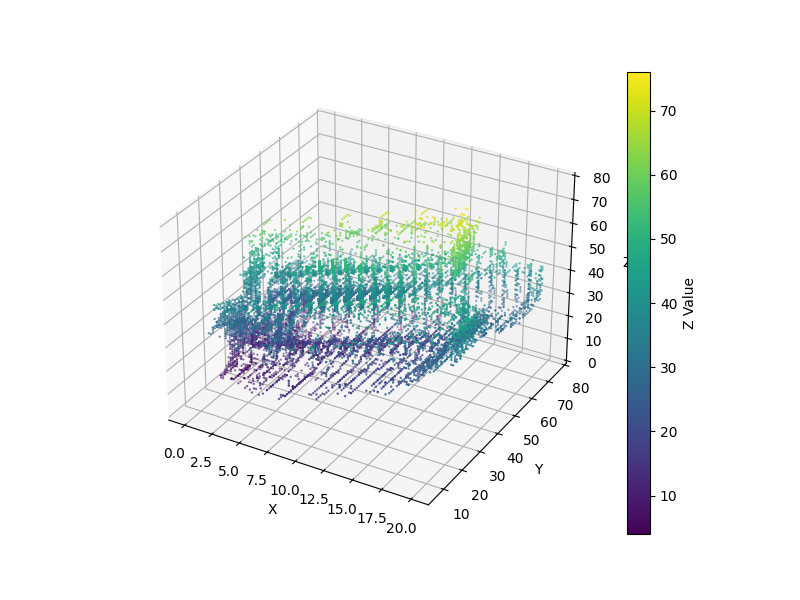

In [294]:
# Enables interactive backend for Jupyter
# %pip install ipympl
# %matplotlib widget
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

# 1. Generate dummy 3xN data
data=maps#get_pos_id(inputs['input_ids'],maps.unsqueeze(0),processor,canvas_size=30).cpu().numpy()

# 2. Setup figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

# 3. Plot (using the c parameter for color mapping based on Z height)
sc = ax.scatter(data[0], data[1], data[2], c=data[2], cmap='viridis',s=0.5)

# 4. Add a colorbar (optional, but looks nice interactively)
plt.colorbar(sc, label='Z Value')

# 5. Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [300]:


# pos_ids = model.model.get_rope_index(inputs['input_ids'],inputs['image_grid_thw'])[0]
# pos_ids = None
# pos_ids = torch.linspace(0,inputs['input_ids'].shape[1],inputs['input_ids'].shape[1],device=model.device,dtype=int).repeat(3,1,1)
def permute_tensor_contents(x):
    # 1. Generate a random permutation of indices for the total number of elements
    idx = torch.randperm(x.numel(), device=x.device)
    
    # 2. Flatten, reorder using the indices, and reshape back
    return x.view(-1)[idx].view(x.shape)

# pos_ids = permute_tensor_contents(pos_ids)

# pos_ids = torch.ones_like(inputs['input_ids']).repeat(3,1,1)
# Inference: Generation of the output
generated_ids = model.generate(**inputs.to(model.device), max_new_tokens=200)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

["The data organization so far is a sequence of observations, where each observation is a visual snapshot of the environment. The observations are taken in a specific order, and each observation is a 2D image of the environment. The images are not necessarily in chronological order, but the sequence of observations is meant to represent the agent's movement through the environment. The agent's actions are also recorded in the sequence, and the actions are performed in the order they are listed."]


In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Suppose the cat is afraid of the mouse. Is this a typical scenario?"},

        ],
    }
]

# Preparation for inference
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)

tensor([[[  4,  41,  30,  ...,  77, 108,  46]],

        [[ 70,  60,   4,  ...,  27, 101,  70]],

        [[ 70,  70,  93,  ...,  67,  92,  41]]], device='cuda:0')